### Importar Dependencias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [ ]:
#%load_ext nb_black

### Cargar datos desde drive al enterno


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 1. descomprime sin -j (conserva carpetas)
!cd /content/Dataset && unzip -o "/content/drive/MyDrive/dataset.zip"

# 2. si se creó la carpeta madre, sube un nivel
!shopt -s dotglob nullglob
!if [ -d "/content/Dataset/Plant_leave_diseases_dataset_with_augmentation" ]; then \
     mv /content/Dataset/Plant_leave_diseases_dataset_with_augmentation/* /content/Dataset/ ; \
     rmdir /content/Dataset/Plant_leave_diseases_dataset_with_augmentation ; \
  fi

# 3. comprueba
!ls /content/Dataset | wc -l
!ls /content/Dataset | head

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (133).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1330).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1331).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1332).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1333).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1334).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1335).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1336).JP

### Importar el Dataset

In [3]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [4]:
dataset = datasets.ImageFolder("Dataset", transform=transform)
print(dataset)                 # debe mostrar 61 486 imágenes
print(len(dataset.classes))    # 39

Dataset ImageFolder
    Number of datapoints: 61486
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )
39


In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [6]:
indices = list(range(len(dataset)))

In [7]:
split = int(np.floor(0.85 * len(dataset)))  # train_size

In [8]:
validation = int(np.floor(0.70 * split))  # validation

In [9]:
print(0, validation, split, len(dataset))

0 36584 52263 61486


In [10]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :36584
length of validation size :15679
length of test size :24902


In [11]:
np.random.shuffle(indices)

### División en Entrenamiento y Prueba

In [12]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [13]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [14]:
targets_size = len(dataset.class_to_idx)

### Modelo

<b>Ecuacion convolucional : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Aprendizaje por Transferencia

In [23]:
# model = models.vgg16(pretrained=True)

In [ ]:
# for params in model.parameters():
#     params.requires_grad = False

In [ ]:
# model

In [ ]:
# n_features = model.classifier[0].in_features
# n_features

In [ ]:
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, targets_size),
# )

In [ ]:
# model

### Modelado Original

In [15]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
device = torch.device("cuda")

In [18]:
model = CNN(targets_size)

In [19]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [20]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

### Capas

In [21]:
total = sum(1 for m in model.modules() if len(list(m.children())) == 0)
print("Capas hoja (con peso/activación):", total)

Capas hoja (con peso/activación): 33


### Pérdida de Entropía Cruzada con Softmax

In [22]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Descenso de Gradiente por Lotes

In [23]:
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [24]:
device = torch.device("cuda")

In [26]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [27]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 5
)

Epoch : 1/5 Train_loss:2.193 Test_loss:1.364 Duration:0:04:36.911396
Epoch : 2/5 Train_loss:1.271 Test_loss:1.179 Duration:0:04:39.656949
Epoch : 3/5 Train_loss:0.962 Test_loss:1.021 Duration:0:04:38.337505
Epoch : 4/5 Train_loss:0.810 Test_loss:0.782 Duration:0:04:38.876847
Epoch : 5/5 Train_loss:0.657 Test_loss:0.715 Duration:0:04:38.627633


### Guardamos el modelo

In [28]:
  # torch.save(model.state_dict() , 'plant_disease_model_2.pt')

In [34]:
 # from google.colab import files
 # files.download('/content/plant_disease_model_2.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Carga de modelo

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("/content/plant_disease_model_2.pt", map_location=device))
model.to(device)
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
# %matplotlib notebook

### Graficar la Pérdida

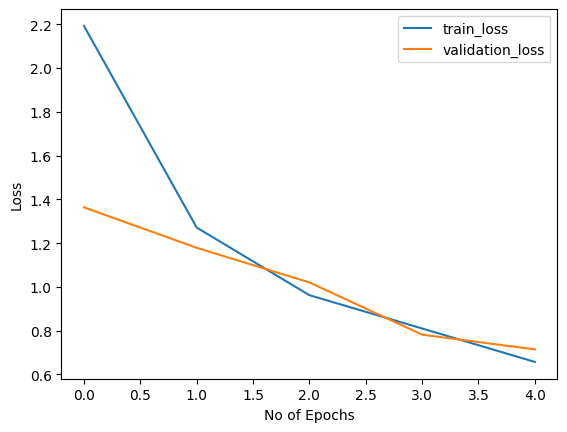

In [30]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Matriz de Confusión + Reporte de Clasificación

                                               precision    recall  f1-score   support

                           Apple___Apple_scab      0.686     0.776     0.728       152
                            Apple___Black_rot      0.913     0.792     0.848       159
                     Apple___Cedar_apple_rust      0.800     0.917     0.855       157
                              Apple___healthy      0.804     0.792     0.798       284
                    Background_without_leaves      0.871     0.937     0.902       158
                          Blueberry___healthy      0.932     0.838     0.882       228
                      Cherry___Powdery_mildew      0.856     0.807     0.831       140
                             Cherry___healthy      0.865     0.925     0.894       160
   Corn___Cercospora_leaf_spot Gray_leaf_spot      0.676     0.593     0.632       123
                           Corn___Common_rust      0.983     1.000     0.991       171
                  Corn___Northern_Leaf_Bli

<Figure size 1200x1000 with 0 Axes>

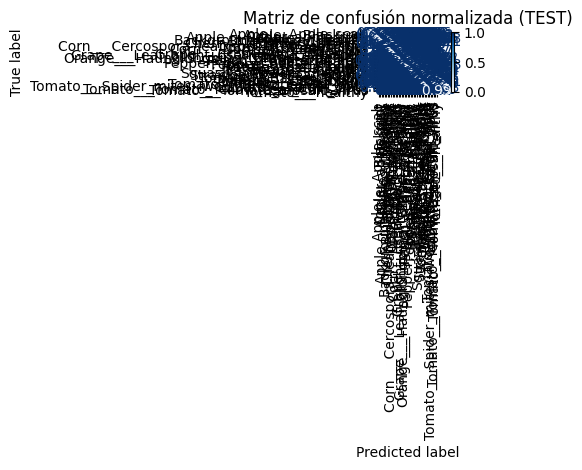

In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true, y_pred = [], []

# --- recorremos el test-loader ----------
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# --- reporte por clase ----------
print(classification_report(y_true, y_pred,
                            target_names=dataset.classes,
                            digits=3, zero_division=0))

# --- matriz de confusión ----------
cm = confusion_matrix(y_true, y_pred, normalize='true')  # 'true' → filas suman 1
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dataset.classes)

plt.figure(figsize=(12,10)) # Set the figure size before plotting
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Matriz de confusión normalizada (TEST)')
plt.tight_layout(); plt.show()

### Curva ROC y umbral de confianza

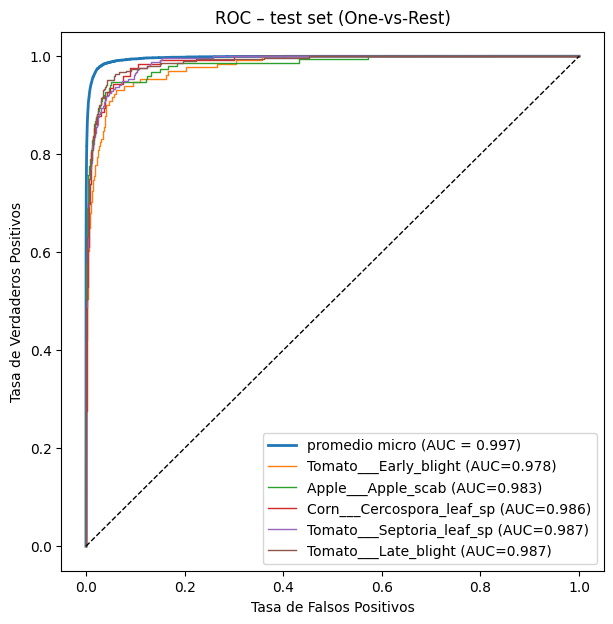

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ---------- necesitamos probabilidades ----------
model.eval()
y_true, y_scores = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_scores.append(probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_true  = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

# ---------- binarización One-vs-Rest ----------
y_bin = label_binarize(y_true, classes=range(targets_size))

# ---------- ROC para cada clase ----------
fpr, tpr, roc_auc = {}, {}, {}
for i in range(targets_size):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ---------- ROC media micro ----------
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ---------- gráfico ----------
plt.figure(figsize=(7,7))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'promedio micro (AUC = {roc_auc["micro"]:.3f})', lw=2)

# (opcional) pintar solo 5 clases con peor AUC para no saturar
worst = sorted([(roc_auc[i], i) for i in range(targets_size)])[:5]
for auc_score, i in worst:
    plt.plot(fpr[i], tpr[i], lw=1,
             label=f'{dataset.classes[i][:25]} (AUC={auc_score:.3f})')

plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('Tasa de Falsos Positivos'); plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('ROC – test set (One-vs-Rest)'); plt.legend(); plt.show()

### Elección de umbral de confianza

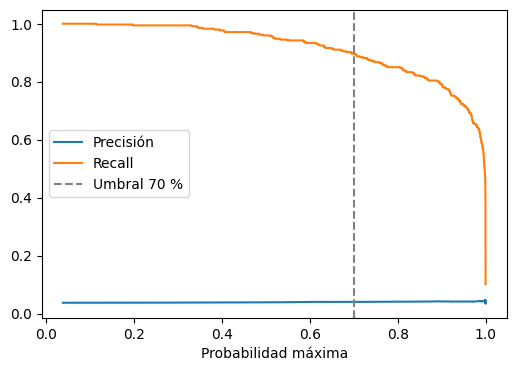

In [41]:
# ---------- curva Precisión-Recall vs umbral ----------
from sklearn.metrics import precision_recall_curve

max_probs = y_scores.max(axis=1)          # confianza de la predicción
precision, recall, thresh = precision_recall_curve(y_true == y_pred, max_probs)

plt.figure(figsize=(6,4))
plt.plot(thresh, precision[:-1], label='Precisión')
plt.plot(thresh, recall[:-1],    label='Recall')
plt.axvline(x=0.70, color='gray', ls='--', label='Umbral 70 %')
plt.xlabel('Probabilidad máxima'); plt.legend(); plt.show()

### Accuracy (Precision)

In [31]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [32]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [33]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9234364749617319
Test Accuracy : 0.9015504716469696
Validation Accuracy : 0.8978888959755087


### Predicción de Imagen Única

In [ ]:
transform_index_to_disease = dataset.class_to_idx

In [ ]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index

In [ ]:
data = pd.read_csv("/content/disease_info.csv", encoding="cp1252")

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF

In [ ]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    input_data = input_data.to(device)  # Move input to the same device as the model
    output = model(input_data)
    output = output.detach().cpu().numpy() # Move output back to CPU for numpy conversion
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

In [ ]:
single_prediction("/content/test_images/Apple_ceder_apple_rust.JPG")

Original :  t_images/Apple_ceder_apple_rust
Apple : Cedar rust


### Predicción Incorrecta

In [ ]:
single_prediction("test_images/Apple_scab.JPG")

Original :  Apple_scab
Apple : Scab


In [ ]:
single_prediction("test_images/Grape_esca.JPG")

Original :  Grape_esca
Grape : Esca | Black Measles


In [ ]:
single_prediction("test_images/apple_black_rot.JPG")

Original :  apple_black_rot
Cherry : Healthy


In [ ]:
single_prediction("test_images/apple_healthy.JPG")

Original :  apple_healthy
Apple : Healthy


In [ ]:
single_prediction("test_images/background_without_leaves.jpg")

Original :  background_without_leaves
Background Without Leaves


In [ ]:
single_prediction("test_images/blueberry_healthy.JPG")

Original :  blueberry_healthy
Blueberry : Healthy


In [ ]:
single_prediction("test_images/cherry_healthy.JPG")

Original :  cherry_healthy
Cherry : Healthy


In [ ]:
single_prediction("test_images/cherry_powdery_mildew.JPG")

Original :  cherry_powdery_mildew
Apple : Cedar rust


In [ ]:
single_prediction("test_images/corn_cercospora_leaf.JPG")

Original :  corn_cercospora_leaf
Corn : Cercospora Leaf Spot | Gray Leaf Spot


In [ ]:
single_prediction("test_images/corn_common_rust.JPG")

Original :  corn_common_rust
Corn : Common Rust


In [ ]:
single_prediction("test_images/corn_healthy.jpg")

Original :  corn_healthy
Corn : Healthy


In [ ]:
single_prediction("test_images/corn_northen_leaf_blight.JPG")

Original :  corn_northen_leaf_blight
Corn : Cercospora Leaf Spot | Gray Leaf Spot


In [ ]:
single_prediction("test_images/grape_black_rot.JPG")

Original :  grape_black_rot
Grape : Black Rot


In [ ]:
single_prediction("test_images/grape_healthy.JPG")

Original :  grape_healthy
Grape : Healthy


In [ ]:
single_prediction("test_images/grape_leaf_blight.JPG")

Original :  grape_leaf_blight
Grape : Black Rot


In [ ]:
single_prediction("test_images/orange_haunglongbing.JPG")

Original :  orange_haunglongbing
Orange : Haunglongbing | Citrus Greening


In [ ]:
single_prediction("test_images/peach_bacterial_spot.JPG")

Original :  peach_bacterial_spot
Peach : Bacterial Spot


In [ ]:
single_prediction("test_images/peach_healthy.JPG")

Original :  peach_healthy
Peach : Healthy


In [ ]:
single_prediction("test_images/pepper_bacterial_spot.JPG")

Original :  pepper_bacterial_spot
Tomato : Leaf Mold


In [ ]:
single_prediction("test_images/pepper_bell_healthy.JPG")

Original :  pepper_bell_healthy
Pepper bell : Healthy


In [ ]:
single_prediction("test_images/potato_early_blight.JPG")

Original :  potato_early_blight
Potato : Early Blight


In [ ]:
single_prediction("test_images/potato_healthy.JPG")

Original :  potato_healthy
Potato : Healthy


In [ ]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [ ]:
single_prediction("test_images/raspberry_healthy.JPG")

Original :  raspberry_healthy
Raspberry : Healthy


In [ ]:
single_prediction("test_images/soyaben healthy.JPG")

Original :  soyaben healthy
Soybean : Healthy


In [ ]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [ ]:
single_prediction("test_images/squash_powdery_mildew.JPG")

Original :  squash_powdery_mildew
Squash : Powdery Mildew


In [ ]:
single_prediction("test_images/starwberry_healthy.JPG")

Original :  starwberry_healthy
Strawberry : Healthy


In [ ]:
single_prediction("test_images/starwberry_leaf_scorch.JPG")

Original :  starwberry_leaf_scorch
Strawberry : Leaf Scorch


In [ ]:
single_prediction("test_images/tomato_bacterial_spot.JPG")

Original :  tomato_bacterial_spot
Tomato : Early Blight


In [ ]:
single_prediction("test_images/tomato_early_blight.JPG")

Original :  tomato_early_blight
Tomato : Early Blight


In [ ]:
single_prediction("test_images/tomato_healthy.JPG")

Original :  tomato_healthy
Tomato : Healthy


In [ ]:
single_prediction("test_images/tomato_late_blight.JPG")

Original :  tomato_late_blight
Tomato : Late Blight


In [ ]:
single_prediction("test_images/tomato_leaf_mold.JPG")

Original :  tomato_leaf_mold
Tomato : Leaf Mold


In [ ]:
single_prediction("test_images/tomato_mosaic_virus.JPG")

Original :  tomato_mosaic_virus
Tomato : Mosaic Virus


In [ ]:
single_prediction("test_images/tomato_septoria_leaf_spot.JPG")

Original :  tomato_septoria_leaf_spot
Tomato : Septoria Leaf Spot


In [ ]:
single_prediction("test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

Original :  tomato_spider_mites_two_spotted_spider_mites
Tomato : Spider Mites | Two-Spotted Spider Mite


In [ ]:
single_prediction("test_images/tomato_target_spot.JPG")

Original :  tomato_target_spot
Tomato : Target Spot


In [ ]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus.JPG")

Original :  tomato_yellow_leaf_curl_virus
Tomato : Yellow Leaf Curl Virus


In [ ]:
single_prediction("/content/test_images/tomate_fungica.jpg")

Original :  t_images/tomate_fungica
Corn : Common Rust


In [ ]:
single_prediction("/content/test_images/tomate_hongo_septoria.jpg")

Original :  t_images/tomate_hongo_septoria
Tomato : Yellow Leaf Curl Virus


In [ ]:
single_prediction("/content/test_images/tomate_plaga.jpg")

Original :  t_images/tomate_hongo_septoria
Tomato : Yellow Leaf Curl Virus


In [ ]:
img_path = "/content/test_images/blueberry_healthy.JPG"

Tomato___Tomato_Yellow_Leaf_Curl_Virus   100.0 %
Corn___healthy                             0.0 %
Orange___Haunglongbing_(Citrus_greening)   0.0 %


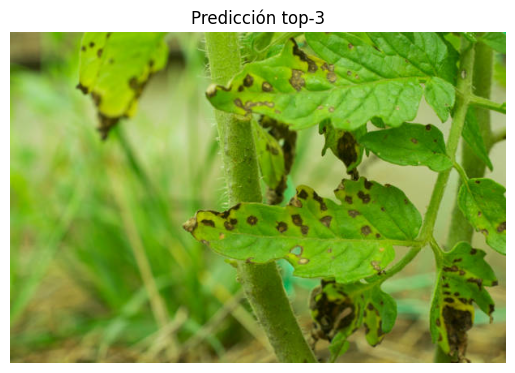

In [ ]:
import torch, torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- mismo transform que usaste ----------
transform = T.Compose([
    T.Resize(255),
    T.CenterCrop(224),
    T.ToTensor()
])

# ---------- cargar modelo ----------
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("/content/plant_disease_model_1.pt", map_location=device))
model.to(device)
model.eval()

# ---------- inferencia ----------
def predict_image(image_path, top_k=3):
    img = Image.open(image_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        probs  = torch.softmax(logits, dim=1)
        top_p, top_idx = torch.topk(probs[0], top_k)

    # mapeo índice → nombre
    class_names = dataset.classes          # lo tienes del ImageFolder
    return [(class_names[i], float(p)) for i, p in zip(top_idx, top_p)], img

# ---------- probar ----------
top3, img = predict_image(img_path, top_k=3)

# ---------- mostrar ----------
plt.imshow(img)
plt.axis('off')
plt.title("Predicción top-3")
for cls, p in top3:
    print(f"{cls:40} {p*100:5.1f} %")

In [ ]:
# Calculate mean and std for normalization using the training data
mean = 0.
std = 0.
nb_samples = 0.
for inputs, _ in train_loader:
    batch_samples = inputs.size(0)
    inputs = inputs.view(batch_samples, inputs.size(1), -1)
    mean += inputs.mean(2).sum(0)
    std += inputs.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Mean of training data: {mean}")
print(f"Std of training data: {std}")

Mean of training data: tensor([0.4393, 0.4781, 0.3758])
Std of training data: tensor([0.1684, 0.1429, 0.1830])
